In [1]:
import pandas as pd
import os

In [2]:
# Ingest Data and Format Data
orders = pd.read_csv('sample_orders.csv')
orders.head()
orders['time_opened'] = pd.to_datetime(orders.time_opened, format='%Y-%m-%d %H:%M:%S')

In [3]:
# Clean Data
orders.isna().any()
orders.duplicated()
orders = orders[orders['time_opened'].notna()]
datatypes = orders.dtypes
datatypes

time_opened    datetime64[ns]
customer_id             int64
subtotal                int64
dtype: object

In [4]:
orders.sort_values(by=['time_opened'])
orders.head()
orders.tail()

,time_opened,customer_id,subtotal
2069,2021-02-02 12:32:00,-2265142484842325716,2785
2070,2021-02-02 12:22:00,8650674892838146900,1095
2071,2021-02-02 12:19:00,3239327921163769940,2756
2072,2021-02-02 11:57:00,-4232627864862634521,1879
2073,2021-02-02 11:17:00,-6922689081798424925,1498


In [5]:
# Obtain Quick View of Data
orders.describe()

,customer_id,subtotal
count,2.070000e+03,2070.000000
mean,-1.670216e+17,2680.679710
std,5.258884e+18,1661.639417
min,-9.189494e+18,0.000000
25%,-4.711932e+18,1350.000000
50%,-3.805385e+17,2442.000000
75%,4.302002e+18,3522.750000
max,9.208736e+18,21797.000000


In [6]:
# Identify Unique Number of Customer in Dataset
n = len(pd.unique(orders['customer_id']))
print("No.of.unique values :", n)

No.of.unique values : 1510


In [7]:
# Create Column for Day of the Week 
orders['DayoftheWeek'] = pd.to_datetime(orders['time_opened']).dt.day_name()
orders

,time_opened,customer_id,subtotal,DayoftheWeek
0,2021-03-21 14:59:00,6817477549539290782,1425,Sunday
1,2021-03-21 14:57:00,-3800621525528210837,1945,Sunday
2,2021-03-21 14:44:00,1700619512948954193,3545,Sunday
3,2021-03-21 14:03:00,-5967439858060002332,1350,Sunday
4,2021-03-21 14:01:00,-74915147466482434,3195,Sunday
...,...,...,...,...
2069,2021-02-02 12:32:00,-2265142484842325716,2785,Tuesday
2070,2021-02-02 12:22:00,8650674892838146900,1095,Tuesday
2071,2021-02-02 12:19:00,3239327921163769940,2756,Tuesday
2072,2021-02-02 11:57:00,-4232627864862634521,1879,Tuesday


In [8]:
# Identify Which Day of Week Had Highest Total Sales for the Period
orders.groupby(orders['time_opened'].dt.day_name()).sum()

,customer_id,subtotal
time_opened,,
Friday,-3.334542e+19,974963.0
Monday,-1.203264e+20,486168.0
Saturday,-6.367293e+19,1337284.0
Sunday,-8.392601e+19,998163.0
Thursday,-1.343068e+20,582556.0
Tuesday,3.025812e+19,483954.0
Wednesday,5.958470e+19,685919.0


## Cohort Analysis

In [9]:
import pandas as pd
import seaborn as sns
import dateutil
import warnings
from datetime import datetime as dt
from pytz import utc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from operator import attrgetter
import matplotlib.colors as mcolors
pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2
%matplotlib inline

In [10]:
#Ingest and Clean Data
cohort = pd.read_csv('sample_orders.csv', dtype={'CustomerID':str}, parse_dates=['time_opened'],infer_datetime_format=True)
cohort.head()

,time_opened,customer_id,subtotal
0,2021-03-21 14:59:00,6817477549539290782,1425
1,2021-03-21 14:57:00,-3800621525528210837,1945
2,2021-03-21 14:44:00,1700619512948954193,3545
3,2021-03-21 14:03:00,-5967439858060002332,1350
4,2021-03-21 14:01:00,-74915147466482434,3195


In [11]:
# Clean and Remove NAs
cohort.dropna(subset=['time_opened'], inplace=True)
cohort.describe()

,customer_id,subtotal
count,2.070000e+03,2070.000000
mean,-1.670216e+17,2680.679710
std,5.258884e+18,1661.639417
min,-9.189494e+18,0.000000
25%,-4.711932e+18,1350.000000
50%,-3.805385e+17,2442.000000
75%,4.302002e+18,3522.750000
max,9.208736e+18,21797.000000


In [12]:
# Identify Customer Who Ordered More Than Once
n_orders = cohort.groupby(['customer_id'])['time_opened'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / cohort['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

20.60% of customers ordered more than once.


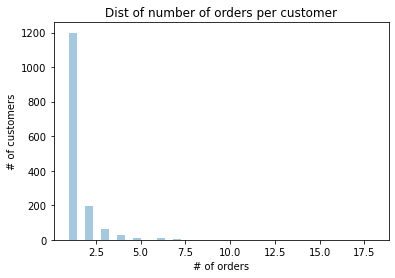

In [13]:
# Visualize Frequency of Orders by Individual Customers
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Dist of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');
# Most customers (roughly 1200) ordered less than 2.5 times in the time period (i.e most only placed 1 order)

In [14]:
# Establish Periods for Cohort Analysis - I Used Weeks
cohort['order_week'] = cohort['time_opened'].dt.to_period('W')
cohort['cohort'] = cohort.groupby('customer_id')['time_opened']\
.transform('min') \
.dt.to_period('W')

In [15]:
cohort_cohort = cohort.groupby(['cohort', 'order_week']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
cohort_cohort['period_number'] = (cohort_cohort.order_week - cohort_cohort.cohort).apply(attrgetter('n'))

In [16]:
cohort_pivot = cohort_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [17]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

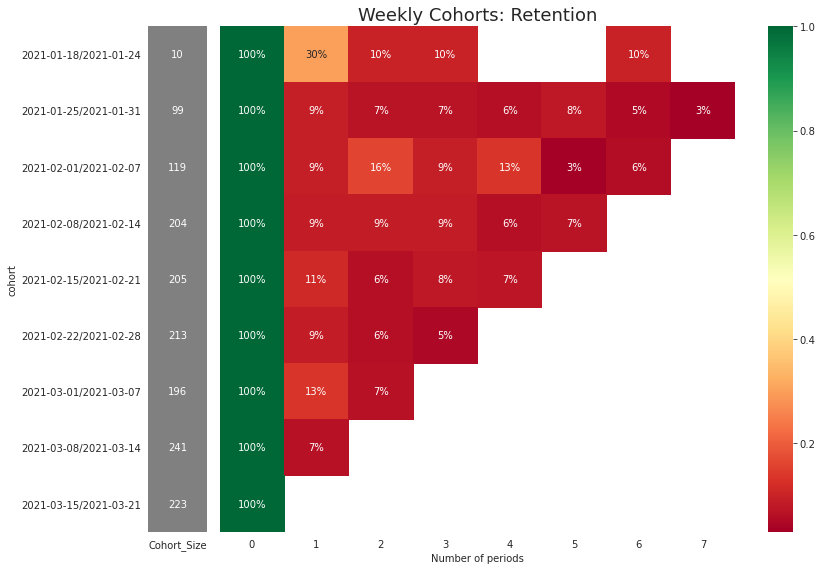

In [18]:
# Create Retention Visualization of Cohorts
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Weekly Cohorts: Retention', fontsize=18)
    ax[1].set(xlabel='Number of periods',
              ylabel='')

    # cohort size
    cohort_size_cohort = pd.DataFrame(cohort_size).rename(columns={0: 'Cohort_Size'})
    white_cmap = mcolors.ListedColormap(['grey'])
    sns.heatmap(cohort_size_cohort, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Displayed is the Weekly Retention of the Customers     
## On average, around 88% of customers don't make second purchase in the second week! High churn and low retention exist. 
## An uptick in Cohort Size occurred after the second week. 
## The more in the red each box is, the less the retetion %

## Customer Lifetime Value

In [19]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [20]:
# Ingest Data
clvdata = pd.read_csv('sample_orders.csv')
clvdata['time_opened'] = pd.to_datetime(clvdata.time_opened, format='%Y-%m-%d %H:%M:%S')
clvdata.head()

,time_opened,customer_id,subtotal
0,2021-03-21 14:59:00,6817477549539290782,1425
1,2021-03-21 14:57:00,-3800621525528210837,1945
2,2021-03-21 14:44:00,1700619512948954193,3545
3,2021-03-21 14:03:00,-5967439858060002332,1350
4,2021-03-21 14:01:00,-74915147466482434,3195


In [21]:
# Clean Data
filtered_clv = clvdata[clvdata['time_opened'].notna()]
filtered_clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2070 entries, 0 to 2073
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time_opened  2070 non-null   datetime64[ns]
 1   customer_id  2070 non-null   int64         
 2   subtotal     2070 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 64.7 KB


In [22]:
# Quick View of Data
filtered_clv.describe()

,customer_id,subtotal
count,2.070000e+03,2070.000000
mean,-1.670216e+17,2680.679710
std,5.258884e+18,1661.639417
min,-9.189494e+18,0.000000
25%,-4.711932e+18,1350.000000
50%,-3.805385e+17,2442.000000
75%,4.302002e+18,3522.750000
max,9.208736e+18,21797.000000


In [23]:
# Filter Data to Track Orders That Generated Revenue
filtered_clv = filtered_clv[(filtered_clv['subtotal']>0)]
filtered_clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2073
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time_opened  2068 non-null   datetime64[ns]
 1   customer_id  2068 non-null   int64         
 2   subtotal     2068 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 64.6 KB


In [24]:
filtered_clv_group=filtered_clv.groupby('customer_id').agg({'time_opened': lambda date: (date.max() - date.min()).days, #number of days between 1st and last date of purch.
                                        'customer_id': lambda num: len(num), # numbr of purchases by customer
                                        'subtotal': lambda price: price.sum()}) # sum of purchases by customer

In [25]:
# Identify Days Between Customer Purchases, Number of Purchases, and Cumulatve Dollars Spent by Customer
filtered_clv_group.head()
# Rename Headers
filtered_clv_group.columns=['days_since','num_purchases','dollars_spent']
filtered_clv_group.head()

,days_since,num_purchases,dollars_spent
customer_id,,,
-9189494013807213137,0,1,2450
-9189345108294282064,0,1,5284
-9150175299243922511,4,2,8654
-9137393404240896794,24,6,20415
-9135541932270606209,8,3,4015


In [26]:
# Calculate Customer Lifetime Value - CLTV = ARPU(revenue in timeperiod/number of users in tp)/ Revenue or Customer Churn
# Need to Calculate Revenue in Data's Time Period
filtered_clv_group['average_order_val']=filtered_clv_group['dollars_spent']/filtered_clv_group['num_purchases']
filtered_clv_group.head()

,days_since,num_purchases,dollars_spent,average_order_val
customer_id,,,,
-9189494013807213137,0,1,2450,2450.000000
-9189345108294282064,0,1,5284,5284.000000
-9150175299243922511,4,2,8654,4327.000000
-9137393404240896794,24,6,20415,3402.500000
-9135541932270606209,8,3,4015,1338.333333


In [27]:
# Calculate Order Freq
order_frequency=sum(filtered_clv_group['num_purchases'])/filtered_clv_group.shape[0]


In [28]:
# Calculate Repeat Customers and Non Repeat(Churn)
repeat_rate=filtered_clv_group[filtered_clv_group.num_purchases > 1].shape[0]/filtered_clv_group.shape[0]


In [29]:
# Calculate Churn
churn_rate = 1-repeat_rate

In [30]:
# Identify Freq, Rep, and Churn Rate of Customers
order_frequency, repeat_rate, churn_rate

(1.3695364238410597, 0.2052980132450331, 0.794701986754967)

In [31]:
# Assumption- We derive 20% profit on Total Sales
filtered_clv_group['profit_margin']=filtered_clv_group['dollars_spent']*0.20

In [32]:
# Identify Customer Value
filtered_clv_group['CLV']=(filtered_clv_group['average_order_val']*order_frequency)/churn_rate

In [33]:
# Calculate Customer Lifetime Value
filtered_clv_group['customer_lifetime_value']=filtered_clv_group['CLV']*filtered_clv_group['profit_margin']

In [34]:
## Display 15 CLTV items
filtered_clv_group.head(15)

,days_since,num_purchases,dollars_spent,average_order_val,profit_margin,CLV,customer_lifetime_value
customer_id,,,,,,,
-9189494013807213137,0,1,2450,2450.000000,490.0,4222.166667,2.068862e+06
-9189345108294282064,0,1,5284,5284.000000,1056.8,9106.093333,9.623319e+06
-9150175299243922511,4,2,8654,4327.000000,1730.8,7456.863333,1.290634e+07
-9137393404240896794,24,6,20415,3402.500000,4083.0,5863.641667,2.394125e+07
-9135541932270606209,8,3,4015,1338.333333,803.0,2306.394444,1.852035e+06
-9134582277046685952,21,3,3790,1263.333333,758.0,2177.144444,1.650275e+06
-9120838873387273982,0,1,1350,1350.000000,270.0,2326.500000,6.281550e+05
-9097923235483778475,0,1,2190,2190.000000,438.0,3774.100000,1.653056e+06
-9073506695320019787,5,2,2745,1372.500000,549.0,2365.275000,1.298536e+06
